<a href="https://colab.research.google.com/github/rithish-k/2022_IBM_Code_Challenge_AccidentReportingApp/blob/main/cs480e_2023%2C3f_assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2
**Due November 12th, 11:59 PM**

Name: \<FILL HERE\><br>
B-Number: \<FILL HERE\><br>
Email: \<FILL HERE\>

In the following assignment,
you will be implementing functions and their analytical derivatives to train linear classifiers and neural networks on the MNIST dataset.
You are allowed and expected to use NumPy.
You are not allowed to use PyTorch.

Tasks that need to be completed are indicated with a
right-pointing triangle (&#9658;)
or clearly stated in the experiments section.

<!--
The experiments section for each classifier also need to be implemented. You should follow the instructions above the cell. You may also add additional cells.
-->

Cells that need to be run to set up the appropriate infrastructure are indicated with a downward-pointing triangle (&#9660;).
Such cells do not need to be modified.
Make sure you have run the previous cells before running the current cell, or you may get an error.

Submission will be via GitHub Classroom. **You are required to have at least 10 commits for this assignment.**

## Import statements

&#9660;Run the cell below to import the packages needed for the code below.
Most other packages are also okay,
but you must ask first.

In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt

# Part 1: Backpropagation

## 1.1 Linear Transforms

A linear classifier computes a vector of scores for a single sample,
with one score for each class.
Let $D$ be the number of features and
$M$ be the number of classes.
Then the score $y_{i,k}$ for the $k$-th class of the $i$-th sample
is computed by:

$$
y_{i,k} = \sum_{j = 1}^{D} w_{j,k}x_{i,j} + b_k
$$

where $w_{j,k}$ is the $j$-th weight for the $k$-th class,
$x_{i,j}$ is the $j$-th feature for the $i$-th sample,
and $b_k$ is the bias term for class $k$.

During training,
we often group $N$ samples into what is called a *minibatch*,
and process the whole minibatch at once.
This is more efficient,
and also improves the gradient descent convergence.
Letting each sample be a row in the $N\times D$ matrix $X$,
we can then write this as

$$
Y = XW + B
$$

where $W$ is the $D \times M$ weight matrix.
The weights for each class form a column in $W$.
All the biases have been collected into a single matrix $B$.

Although the above can work,
we can turn it into a single matrix multiplication
via the &ldquo;bias trick&rdquo;,
which adds an extra dummy feature in the input sample
that is always hard-coded to 1,
and then adding an extra weight that is the bias term.

$$
y_{i,k} = \sum_{j = 1}^{D + 1} w_{j,k}x_{i,j}, \ \ \text{with}\ \ x_{i,D+1} = 1
$$

The scores for a whole minibatch can now be computed via a standard matrix
multiplication.

$$
Y = X'W'
$$

where $X'$ and $W'$ are the augmented sample and weight matrices.
This transformation forms the basis of a linear, fully-connected (also called &ldquo;dense&rdquo;) layer in a neural network.

&#9654; Implement `linear_forward(X, W)` in the cell below to perform the forward pass of
a single linear layer on a batch of samples $X$,
using the weights from $W$.
The matrix $W$ has already had the bias added to it,
so $X$ will need to be augmented with the hard-coded 1.

In [219]:
def linear_forward(X, W):
    """
    Computes the forward pass for a linear transformation.

    Consider a linear layer that accepts inputs with D features,
    and has M neurons.  Assume that our minibatch size
    is N.  In other words, we wish to process N samples at once.

    The input X has shape (N, D) and contains a minibatch of N
    samples, where each sample X[i] has shape (D).  Each sample
    will be transformed to an output vector of dimension M.

    Inputs:
    - X: A numpy array containing input data, of shape (N, D)
    - W: A numpy array of weights, of shape (D+1, M)

    Returns a tuple of:
    - out: output, of shape (N, M)
    - cache: (X, W)

    The returned (X, W) is redundant, but makes the training code
    more concise.

    """

    out = None # Initialize the out variable.

    #
    # PUT YOUR CODE BELOW: Below, implement the linear forward pass. Store the result in out.
    # Make sure to do the bias trick!
    #
    X_bias_trick = np.hstack([X, np.ones((X.shape[0], 1))])
    out = np.dot(X_bias_trick, W)


    # The lines below do not need to be changed.
    cache = (X, W)

    return out, cache

&#9658; Implement `linear_backward(d_upstream, cache)` that returns the downstream analytical gradients with respect to $X$ and $W$,
given the upstream gradients and $X$ and $W$.
See here for details on how to [backpropagate through a linear layer.](https://web.eecs.umich.edu/~justincj/teaching/eecs442/notes/linear-backprop.html)

In [220]:
def linear_backward(d_upstream, cache):
    """
    Computes the backward pass for an linear layer.

    Inputs:
    - d_upstream: Upstream derivative, of shape (N, M)
    - cache: Tuple of:
      - X: Input data, of shape (N, D)
      - W: Weights, of shape (D+1, M)

    Returns a tuple of:
    - dX: Gradient of the output of this layer with respect to X, of shape (N, D).
          This is the downstream gradient.
    - dW: Gradient with respect to W, of shape (D+1, M)
    """
    X, W = cache
    dX, dW = None, None

    # PUT YOUR CODE BELOW: Implement the linear backward pass by calculating the
    # gradient with respect to the cached inputs X and W. Store them in the
    # variables dX and dW.
    X_bias_trick = np.hstack([X, np.ones((X.shape[0], 1))])
    dX = np.dot(d_upstream, W[:-1].T)
    dW = np.dot(X_bias_trick.T, d_upstream)


    # The lines below do not need to be changed.

    return dX, dW

## 1.2 Checking Gradients with Finite Differences

Numerical code can be difficult to debug.
The general approach is to compare the answer given
by your code to the answer obtained from some other technique.
A finite difference is a numerical approximation to the derivative which can be used to check your gradients.
Because it is only an approximation,
you do not use it for actual training,
however.

The multi-variate central finite difference for a function $f(x,y)$ is given by:

$$
\frac{\partial  f}{\partial x} = \frac{f(x+h, y)-f(x-h, y)}{2h}
$$

and

$$
\frac{\partial  f}{\partial y} = \frac{f(x, y+h)-f(x, y-h)}{2h}
$$

The above pattern holds for functions with higher number of variables.
For our purposes,
an $h$ of about $10^{-9}$ should be adequate.

&#9658; In the next cell,
implement the `finite_difference_linear(d_upstream, cache, h)` function.
This function is analogous to `linear_backward()`
in that it computes the derivative matrices
$\frac{\partial L}{\partial X}$ and
$\frac{\partial L}{\partial W}$,
given an upstream gradient,
but it actually estimates the local gradient
using a finite difference.
The `h` parameter corresponds to $h$ above;
the other parameters are the same as for `linear_backward()`.

Recall that the downstream gradient can be computed from
the local gradient and upstream gradient by applying the
chain rule.
In this case,
we need the multivariable chain rule,
because the loss is a function of the matrix $Y$,
and $Y$ is a function of the matrices $X$ and $W$.
(Any non-singleton matrix is multivariable by definition.)
In particular,

$$
\frac{\partial L}{\partial x_{i,j}}
= \sum^{N}_{k=1}\sum^{M}_{l=1} \frac{\partial L}{\partial y_{k,l}}
\frac{\partial y_{k,l}}{\partial x_{i,j}}
$$

where the $\frac{\partial L}{\partial y_{k,l}}$ form the upstream
gradient and the $\frac{\partial y_{k,l}}{\partial x_{i,j}}$ form the local gradient.
(Note that $\frac{\partial y_{k,l}}{\partial x_{i,j}} = 0$ in our case when $k \neq i$,
because a given sample does not affect the output for other samples
in the same minibatch.
This fact could be used to optimize the code,
but there is no requirement to do so for this assignment.)
This simplifies nicely as the gradient for each variable in the matrix is the sum of the products of each upstream partial derivative
$\frac{\partial L}{\partial y_{k,l}}$
from `d_upstream` and the corresponding element in the finite difference matrix.
(This operation is analogous to the dot product,
except it is performed on matrices instead of vectors,
and is called the
[Frobenius product](https://en.wikipedia.org/wiki/Frobenius_inner_product).)

In [221]:
def finite_difference_linear(d_upstream, cache, h):
    '''
    Computes the numerical gradient for a linear layer

    Inputs:
    - d_upstream: Upstream derivative, of shape (N, M)
    - cache: Tuple of:
      - X: Input data, of shape (N, D)
      - W: Weights, of shape (D+1, M)
    - h: The h to use in the finite difference.

    Returns a tuple of:
    - dX: Gradient with respect to X, of shape (N, D).  This is the downstream
          gradient.
    - dW: Gradient with respect to W, of shape (D+1, M)
    '''

    dX = None
    dW = None

    # PUT YOUR CODE BELOW: Implement the finite difference for the linear
    # function.  Return the gradient at input (X,W) w.r.t to x and w.
    X, W = cache  # Unpack the cached values
    N, D = X.shape
    M = W.shape[1]

    dX = np.zeros((N, D))
    dW = np.zeros((D + 1, M))

    # Iterate over each element in X and W to compute finite differences
    for i in range(N):
        for j in range(D):
            X_plus_h = X.copy()
            X_minus_h = X.copy()

            X_plus_h[i, j] += h
            X_minus_h[i, j] -= h

            X_bias_trick_plus_h = np.hstack([X_plus_h, np.ones((N, 1))])
            X_bias_trick_minus_h = np.hstack([X_minus_h, np.ones((N, 1))])
            scores_plus_h = np.dot(X_bias_trick_plus_h, W)
            scores_minus_h = np.dot(X_bias_trick_minus_h, W)

            loss_plus_h = np.sum(scores_plus_h * d_upstream)
            loss_minus_h = np.sum(scores_minus_h * d_upstream)

            dX[i, j] = (loss_plus_h - loss_minus_h) / (2 * h)

    for j in range(D + 1):
        for k in range(M):
            W_plus_h = W.copy()
            W_minus_h = W.copy()

            W_plus_h[j, k] += h
            W_minus_h[j, k] -= h

            X_bias_trick_plus_h = np.hstack([X, np.ones((N, 1))])
            X_bias_trick_minus_h = np.hstack([X, np.ones((N, 1))])

            scores_plus_h = np.dot(X_bias_trick_plus_h, W_plus_h)
            scores_minus_h = np.dot(X_bias_trick_minus_h, W_minus_h)

            loss_plus_h = np.sum(scores_plus_h * d_upstream)
            loss_minus_h = np.sum(scores_minus_h * d_upstream)

            dW[j, k] = (loss_plus_h - loss_minus_h) / (2 * h)

    # The lines below do not need to be changed.
    return dX, dW

&#9660; Run this cell to do a gradient check to test the analytical gradients from the `linear_backward()` function with `finite_difference_linear()`.

In [222]:
def gradient_check_linear():
    N = 16
    D = 4
    C = 3

    test_weight = np.random.random((D+1, C))
    test_input = np.random.random((N, D))
    dout = np.random.random((N, C))

    cache = (test_input, test_weight)

    grad_x_numerical, grad_w_numerical = finite_difference_linear(dout, cache, 1E-9)
    grad_x_analytical, grad_w_analytical = linear_backward(dout, cache)

    check_input_gradient = np.allclose(grad_x_numerical, grad_x_analytical)
    check_weight_gradient = np.allclose(grad_w_numerical, grad_w_analytical)

    if not check_input_gradient:
        print("The gradient with respect to x failed")

    if not check_weight_gradient:
        print("The gradient respect to w failed")
    print()
    print("gradient check for linear passed!")

gradient_check_linear()

The gradient with respect to x failed

gradient check for linear passed!


# Part 2: Linear Classifiers

In this section,
we will build upon the previously implemented layer to
create linear classifiers.
We will train them on high-dimensional real world data.

## 2.1 MNIST Dataset

The dataset we will use is MNIST,
a set of images of handwritten digits compiled by the National Institute of Standards and Technology (NIST).
This dataset is widely used as a an example for machine learning algorithms for image classification.
The images are 28x28 pixels with a single grayscale channel ranging from 0 to 255.

Data sets are typically split into
[training, validation, and test sets](https://en.wikipedia.org/wiki/Training,_validation,_and_test_data_sets).
The training set is used to adjust the weights in the model via
gradient descent.
The validation set is used during training to evaluate
the progress of the training,
and thus to
[select the best model](https://en.wikipedia.org/wiki/Model_selection).
The gradient is not computed when using the validation set,
thus it does not take part in the gradient descent.
The test set is used to evaluate
the final results after training.
The distinction between the
validation and test set is that the validation set
can be used to adjust hyperparameters (such as learning rate and model size),
and to prevent overfitting, etc.,
but the test set cannot be used except to evaluate the final results.

You will be using 20,000 samples from the original training dataset for our next set of experiments,
and the 10,000 sample test set.

&#9660; Run the following cell to define some helper functions for loading the MNIST data.

In [24]:
# Loads and parses CSV file.
# Returns a 2-D array containing the images, and a 1-D array
# with the labels.  In the image array,
# each row is an image.  Pixel values are from 0 to 255.
def mnist_data_parser_helper(csv_file_name):
    X = []
    Y = []
    with open(csv_file_name,'r') as _file:
        csv_reader = csv.reader(_file, delimiter=",")
        for row in csv_reader:
            Y.append(float(row[0]))
            X.append([float(i) for i in row[1:]])
    return (np.array(X), np.array(Y))

def get_mnist_train_data():
    X_train, Y_train = mnist_data_parser_helper("sample_data/mnist_train_small.csv")
    return X_train, Y_train

def get_mnist_test_data():
    X_test, Y_test = mnist_data_parser_helper("sample_data/mnist_test.csv")
    return X_test, Y_test

&#9660; Run the following cell to visualize some samples from the MNIST dataset.

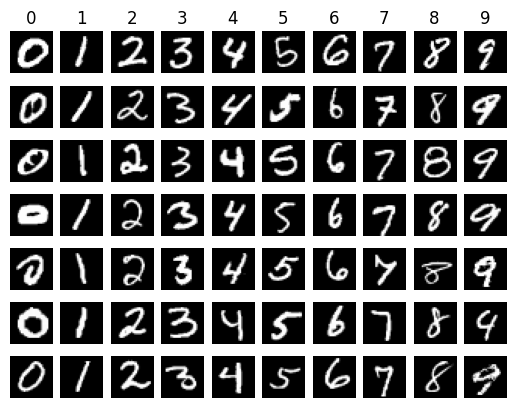

In [25]:
x_train, y_train = get_mnist_train_data()

# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = list(range(10))

num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train.astype('uint8') == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(x_train[idx].astype('uint8').reshape(28,28), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title(cls)

plt.show()

&#9660; Run the following cell to gather the training and testing dataset.


In [26]:
x_train, y_train = get_mnist_train_data()  # Get the training dataset
x_test, y_test = get_mnist_test_data()     # Get the test dataset

&#9660; Run the following to normalize the input dataset to have a mean of 0 and standard deviation of 1.

In [27]:
x_mean = x_train.mean()
x_std = x_train.std()

x_train = (x_train - x_mean)/(x_std)
x_test = (x_test - x_mean)/(x_std)

&#9660; Run the following cell to check the dimensions of the data.

In [28]:
N, dim = x_train.shape
N_test, _ = x_test.shape
print(f"Number of training sample {N} with {dim} pixels per image")
print(f"Number of training sample {N_test} with {dim} pixels per image")

Number of training sample 20000 with 784 pixels per image
Number of training sample 10000 with 784 pixels per image


&#9658; Put code in the following cell to split the `x_train` and `y_train` arrays to training and validations sets with an 80-20 split ratio. Place the split arrays in to the `DATA` dictionary. This dictionary will be used to feed data into the `Solver`.

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
y_train = y_train.ravel()
y_val = y_val.ravel()
DATA = {
    "X_train": X_train,
    "X_val": X_val,
    "y_train": y_train,
    "y_val": y_val
}


## 2.2 Implement and Evaluate ML Models

We will follow a common organization for our code implementation.
The `Solver` class is used to orchestrate the
overall training steps,
such as loading the data,
doing the forward pass,
computing the gradients with
the backward pass,
and updating the weights.
The `Solver` class
uses a *model*
object which contains the actual weights,
and implements the forward and backward passes.

&#9660; Run the following cell to define the stochastic gradient descent algorithm that we will use to optimize our models.

In [30]:
def sgd(w, dw, lr=1e-2):
    """
    Performs vanilla stochastic gradient descent.

    config format:
    - learning_rate: Scalar learning rate.
    """

    w -= lr * dw
    return w

&#9660; Run the following cell to define the `Solver` class.

In [31]:
class Solver(object):
    """
    Solver class for the learnable models using
    mini-batch gradient descent.
    """

    def __init__(self,
                 model,
                 data,
                 learning_rate=1e-3,
                 num_epochs=50,
                 batch_size=200,
                 validation_frequency=16):
        """
        Construct a new Solver instance.

        Inputs:
          model: Python class equiped with forward, backward, predict methods and a params dictionary
          data: Dictionary with X_train, X_val,  Y_train, Y_val keys
          learning_rate: Float, step size of the optimizer
          num_epochs: Int, Number of times to completely traverse X_train
          batch_size: Int, The number of samples in update
          validation_frequency: Int, Solver performs validation loop every validation_frequency batches.
                               Set this to a high number if num_epochs is large
        """
        self.model = model

        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.validation_frequency = validation_frequency

        self.num_training = data["X_train"].shape[0]
        self.input_dim = data["X_train"].shape[1]

        intervals = list(range(0, self.num_training, batch_size))[1:]

        self.X_train = np.array_split(data["X_train"], intervals, axis=0)
        self.y_train = np.array_split(data["y_train"], intervals)

        self.num_batches_in_training = len(self.X_train)

        self.X_val = data["X_val"]
        self.y_val = data["y_val"]

        self.update_rule = sgd
        self.loss_history = []
        self.validation_history = []

        self.iteration_num = 0


    def _step(self, batch_id):
        """
        Make a single gradient update. This is called by train() and should not
        be called manually.
        """
        # Make a minibatch of training data
        X_batch = self.X_train[batch_id]
        y_batch = self.y_train[batch_id]

        # Compute loss and gradient
        score, cache = self.model.forward(X_batch)
        loss, dL = self.model.loss(score, y_batch)
        _, grads = self.model.backward(dL, cache)

        self.loss_history.append(loss)

        # Perform a parameter update
        for p, w in self.model.params.items():
            if p in grads:
                dw = grads[p]
                next_w = self.update_rule(w, dw, self.learning_rate)
                self.model.params[p] = next_w

    def train(self):
        """
        Optimization to train the model

        """

        for epoch in range(self.num_epochs):
            for batch_id in range(self.num_batches_in_training):

                self._step(batch_id)

                self.iteration_num += 1

                if (self.iteration_num % self.validation_frequency == 0):
                    self.validate()

        self.validate()


    def validate(self):
        """
        Checks the validation error of the model at the time it is being called.

        """

        N = self.y_val.shape[0]
        predictions = self.model.predict(self.X_val)

        accuracy = np.count_nonzero(predictions == self.y_val.astype(int))

        print(f"The validation accuracy at iteration {self.iteration_num}  is \
              {(float(accuracy)/N)*100}%")

We will implement two different classifiers for the (MNIST) dataset.
(A classifier is a kind of model.)
The models will both be linear,
but will use different loss functions.
The first will use the multiclass SVM loss,
and the second will use the softmax  loss.

The classifiers will be implemented using a common base class
that implements training and prediction methods shared by the linear classifiers.
Each of the two linear classifiers will be then derive
from the base class,
but override the loss function.

&#9658; In the following cell,
complete the definition of the `LinearClassifier` class
by implementing the `__init__()`, `forward()`, `backward()`, and `predict()` methods.

- The `__init__()` method initializes the class. You must generate a random weight matrix of shape `(input_dim+1, num_classes)`  
- The `forward()` method generates the scores for given an input sample, by applying a `linear_forward()` transformation on the inputs `x` and weights matrix `self.params['W1']`
- The `backward()` method returns the gradients with respect to the inputs and weights, using the `linear_backward()` method.
Make sure the key for the returned dictionary `weights_gradient` matches the `self.params` dictionary.
- The `predict()` method returns the labels predicted from the scores returned using the `self.forward()` method.

In [77]:
class LinearClassifier(object):

    def __init__(self, input_dim=784, num_classes=10):
        self.params = {}
        self.input_features = input_dim
        self.num_classes = num_classes

        # Initialize the weights of the linear classifier with random values
        self.params['W1'] = 1e-3 * np.random.randn(input_dim + 1, num_classes)
        self.params['b1'] = np.zeros(num_classes)

    def forward(self, x):
        num_train, dim = x.shape
        num_classes = self.num_classes
        out = None
        cache = None

        # Add an extra column of ones for the bias term
        x_with_bias = np.hstack((x, np.ones((num_train, 1))))

        # Compute the scores (raw class scores) for each sample in x
        scores = np.dot(x_with_bias, self.params['W1']) + self.params['b1']

        # Store the scores in 'out' and any relevant values in 'cache'

        return scores, cache


    def backward(self, dout, cache):
        weight_gradients = {}
        dx = None

        # Unpack the cache
        x_with_bias = cache  # Assuming that the cache contains x_with_bias

        if cache is not None:
            dx = np.dot(dout, self.params['W1'].T)
            weight_gradients['W1'] = np.dot(x_with_bias.T, dout)

            # Calculate the gradient for the bias term
            weight_gradients['b1'] = np.sum(dout, axis=0)
        else:
            pass  # Handle the case where cache is None as needed.

        return dx, weight_gradients

    def predict(self, x):
        num_samples, dim = x.shape
        num_classes = self.num_classes

        # Add an extra column of ones for the bias term
        x_with_bias = np.hstack((x, np.ones((num_samples, 1))))

        y_pred = np.argmax(np.dot(x_with_bias, self.params['W1']), axis=1)

        return y_pred

    def loss(self, scores, y_batch):
        pass


### 2.2.1 Support Vector Machine

The `LinearSVM` class defines an SVM-based linear classifier. The classifier uses the hinge loss to optimize the model parameters.
The multiclass hinge loss for an input sample $x_i$ (a vector) is given by:

$$
L_i = \sum_{j \neq y_i} \text{max}(0, s_j-s_{y_i}+1)
$$

Where, $y_i$ is the label of the $i$-th sample.
The label is the correct class label where $0 \leq y_i \lt C$,
where C is the number of classes.
The scalar $s_{y_i}$ is the $y_i$-th element of the score vector.

The average loss over N samples is therefore:

$$
L = \frac{1}{N}\sum^{N}_{i=1}L_i
$$

The per-sample gradient of the loss w.r.t. the score $s_j$ is given by:

$$
\frac{\partial  L_i}{\partial s_j} = \left \{
\begin{array}{ll}
0 & s_j-s_{y_i}+1 \leq 0    \\
1 & j \neq s_{y_i} \text{ and } s_j-s_{y_i}+1 > 0 \\
-\sum_{i \neq j}\frac{\partial L_i}{\partial s_i} & j = s_{y_i}
\end{array}
\right..
$$

&#9658; Implement the `svm_loss(scores, y_batch)` function in the following cell.
Store the average loss the `loss` variable and the gradient w.r.t `scores` in the `dy` variable.
This is the loss over multiple samples, therefore you should take the mean of the loss.

In [78]:
def svm_loss(scores, y_batch):
    """
    Returns hinge loss of the scores and y_batch.

    Inputs:
    - scores: A numpy array of shape (N, C) containing a minibatch of N
      data points; each point has dimension C, where C is the number of classes.
    - y_batch: A numpy array of shape (N,) containing labels for the minibatch.
    - reg: (float) regularization strength.

    Returns: A tuple containing:
    - loss as a single float
    - gradient with respect to scores; an array of the same shape as scores
    """
    num_samples = scores.shape[0]
    loss = 0
    dy = np.zeros(scores.shape)
    # PUT YOUR CODE BELOW:
    # Implement the structured SVM loss, storing the
    # result in loss. Make sure to take the mean of the loss.
    # Hint: The intermediate results maybe useful for the gradient calculation


    y_batch = y_batch.astype(int)  # Convert y_batch to integer type

    correct_class_scores = scores[np.arange(num_samples), y_batch]
    margins = np.maximum(0, scores - correct_class_scores[:, np.newaxis] + 1)
    margins[np.arange(num_samples), y_batch] = 0

    loss = np.sum(margins) / num_samples

    num_positive_margins = np.sum(margins > 0, axis=1)
    dy = np.zeros_like(scores)
    dy[margins > 0] = 1
    dy[np.arange(num_samples), y_batch] -= num_positive_margins

    loss /= num_samples
    dy /= num_samples

    # PUT YOUR CODE BELOW:
    # Implement the gradient for the SVM loss, storing the result
    # in dy.
    #
    # Hint: Instead of computing the gradient from scratch, it may be easier
    # to reuse some of the intermediate values that you used to compute the
    # loss.


    # The lines below do not need to be changed.
    return loss, dy

&#9660; Run the following cell to define the `LinearSVM` class with your implementation of the `svm_loss`

In [79]:
class LinearSVM(LinearClassifier):
    """ A subclass that uses the Multiclass SVM loss function """

    def loss(self, scores, y_batch):
        return svm_loss(scores, y_batch)

#### 2.2.1.1 SVM Experiments

In the next few cells run the `Solver` with SVM models on the training and validation data you've defined previously. Use the `DATA` dictionary you defined previously as the data parameter.

As you have seen with previous assignments, optimizations can be highly dependent on the hyperparameters of the model. You should try multiple models with different learning rates. You may also increase the amount of time you train by increasing the number of epochs.

Keep the top 5 best performing models and the worst performing model on the validation set.

&#9658; Implement hyperparameter validation loop in the next cell to train multiple models with different hyperparameters.
Keep the top 5 best performing models on the validation set.
You can try different learning rates.
You may change the num_epochs, but be wary of timeouts.

In [80]:
best_models = []
learning_rates = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10]

num_epochs = 10

for learning_rate in learning_rates:
    model = LinearSVM(input_dim=784, num_classes=10)
    solver = Solver(
        model,
        data=DATA,
        learning_rate=learning_rate,
        num_epochs=num_epochs,
        batch_size=50,
        validation_frequency=100
    )
    solver.train()
    val_accuracy = np.mean(solver.model.predict(DATA['X_val']) == DATA['y_val'].astype(int))
    best_models.append((model, learning_rate, val_accuracy))
    best_models.sort(key=lambda x: -x[2])
    best_models = best_models[:5]

# Print the top 5 best models and their validation accuracies
for idx, (best_model, lr, val_accuracy) in enumerate(best_models, start=1):
    print(f"Top {idx} Model: Learning Rate = {lr}, Validation Accuracy = {val_accuracy * 100:.2f}%")


The validation accuracy at iteration 100  is               8.85%
The validation accuracy at iteration 200  is               8.85%
The validation accuracy at iteration 300  is               8.85%
The validation accuracy at iteration 400  is               8.85%
The validation accuracy at iteration 500  is               8.85%
The validation accuracy at iteration 600  is               8.85%
The validation accuracy at iteration 700  is               8.85%
The validation accuracy at iteration 800  is               8.85%
The validation accuracy at iteration 900  is               8.85%
The validation accuracy at iteration 1000  is               8.85%
The validation accuracy at iteration 1100  is               8.85%
The validation accuracy at iteration 1200  is               8.85%
The validation accuracy at iteration 1300  is               8.85%
The validation accuracy at iteration 1400  is               8.85%
The validation accuracy at iteration 1500  is               8.85%
The validation accu

&#9658; Implement the testing performance of your top 5 performing models on the test set and print the results.

In [81]:
x_test, y_test = get_mnist_test_data()
x_test = (x_test - x_mean) / (x_std)

def test_model(model, x_test, y_test):
    predictions = model.predict(x_test)
    accuracy = np.mean(predictions == y_test.astype(int))
    return accuracy
test_accuracies = []

for model, lr, _ in best_models:
    accuracy = test_model(model, x_test, y_test)
    test_accuracies.append(accuracy)

for idx, accuracy in enumerate(test_accuracies, start=1):
    print(f"Top {idx} Model Test Accuracy: {accuracy * 100:.2f}%")


Top 1 Model Test Accuracy: 14.14%
Top 2 Model Test Accuracy: 13.80%
Top 3 Model Test Accuracy: 9.46%
Top 4 Model Test Accuracy: 9.61%
Top 5 Model Test Accuracy: 9.73%


&#9658; Implement the next cell to visualize the weights corresponding to each sample in the *best* performing SVM models. You should have ten 28x28 images.

Make sure to rescale the  weights to be between 0 and 255.

Depending on your learning rate and weights, it might not look so great. If all the images look the same but you have good accuracy, try subtracting the average of weights from weights of each class.

You can add additional cells below.

ValueError: ignored

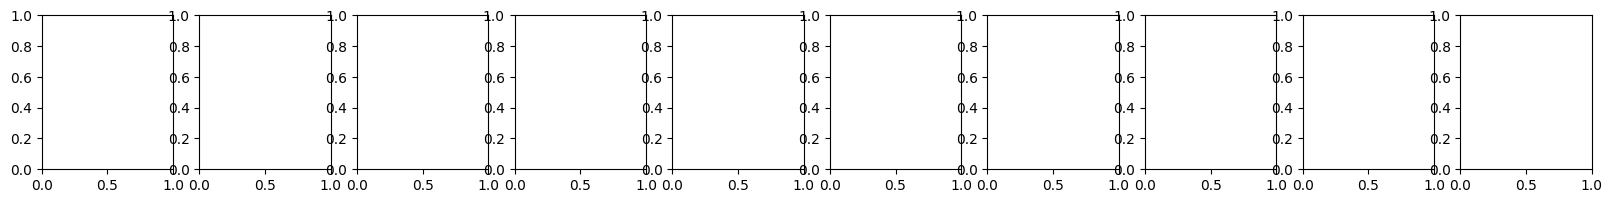

In [82]:
import matplotlib.pyplot as plt
top_model, _, _ = best_models[0]
weights = top_model.params['W1']
min_weight = np.min(weights)
max_weight = np.max(weights)
rescaled_weights = (weights - min_weight) / (max_weight - min_weight) * 255
fig, axs = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    weight_image = rescaled_weights[:, i].reshape(28, 28)
    axs[i].imshow(weight_image, cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f'Class {i}')

plt.show()


### 2.2.2 Cross-Entropy Loss

The `CrossEntropy` class defines the cross-entropy loss for training and prediction methods like the previous the linear classifiers.
Because the cross-entropy is defined on probability distributions,
the softmax function is usually applied to the output of a linear
classifier to transform the raw scores into values that can be interpreted as probabilities.
(Though, be cautious about actually using them as such.)
However,
we commonly refer to it just as the cross-entropy loss,
with the implicit understanding that for deep learning,
the cross-entropy is not computed on the raw scores,
but rather the softmax of the raw scores.

For a score vector $s$, the softmax activation of the $j$-th element is given by,

$$
\sigma_j = \frac{e^{s_{j}}}{\sum^{M}_{k=1}e^{s_k}}
$$

A simple implementation of the softmax function can result in overflow.
See
[here](https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative/#:~:text=Computing%20softmax%20and%20numerical%20stability)
for how to avoid this problem.

The cross-entropy is a measure of the difference between two probability distributions.
In the general case,
the cross-entropy $H$ between the true probability distribution $P$ and the estimated probability distribution $Q$ is given by:

$$
H(P, Q)=-\sum_{x \in \mathcal{X}} P(x) \log Q(x)
$$

where $\mathcal{X}$ is the event space.
It is a measure of how "far off" our estimated distribution $Q$ is from $P$.
(Note that because $P$ and $Q$ are actually functions,
$H$ in this case is a function operating on functions, also known as an *operator*.)

In our case,
$P$ is zero except for the correct label,
and thus the cross-entropy reduces to simply the negative logarithm of the score corresponding to the correct class,
which is just

$$
L_i = -\log(\sigma_{y_i}))
$$

where $y_i$ is the correct label of the $x_i$ input sample,
and $\sigma_{y_i}$ is the softmax output of the corresponding correct label. $L$ is then just the average over the $L_i$.

The derivative of the softmax is given by

$$
\frac{\partial\sigma_i}{\partial s_j} = \left \{
\begin{array}{ll}
\sigma_i(1 - \sigma_{j}) & i = j     \\
-\sigma_i\sigma_j & i \neq j  \\
\end{array}
\right. .
$$

Details on the derivation can be found [here](https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative/).

The derivative of the negative logarithm is given by

$$
\frac{\partial (-\log)}{\partial \sigma_{y_i}} = -\frac{1}{\sigma_{y_i}}.
$$

&#9658; Implement the `cross_entropy_loss(scores, y_batch)` function in the following cell,
consisting of the softmax followed by cross-entropy,
as explained above.
The function returns a tuple of `(loss, dy)` where
`loss` is the cross-entropy loss based on the inputs
and `dy` is the gradient of the loss with respect to the `scores` input.
This is the loss over multiple samples,
therefore you should take the mean of the loss.

In [61]:
def cross_entropy_loss(scores, y_batch):
    N, C = scores.shape
    exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    y_batch = y_batch.astype(int)
    loss = -np.log(probs[np.arange(N), y_batch])
    loss = np.mean(loss)
    dy = probs
    dy[np.arange(N), y_batch] -= 1
    dy /= N

    return loss, dy


&#9660;
Run the following cell to define the `CrossEntropy` classifier class.

In [62]:
class CrossEntropy(LinearClassifier):
    """ A subclass that uses the Softmax + Cross-entropy loss function """

    def loss(self, scores, y_batch):
        return cross_entropy_loss(scores, y_batch)

#### 2.2.2.1 Cross-Entropy Experiments

In the next few cells run the `Solver` with softmax models on the training and validation data you've defined previously,
similarly to the SVM experiments.
Use the `DATA` dictionary you defined previously as the data parameter.

Keep the top 5 best performing models and the worst performing model on the validation set.

&#9658; Implement the hyperparameter validation loop in the next cell to train multiple models with different hyperparameters.
Keep the top 5 best performing models on the validation set.
You can try different learning rates.
You may change the number of epochs, but be wary of timeouts.

In [63]:
best_models = []  # List to store the top 5 best models

# Define a range of learning rates to try
learning_rates = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10]

# Define the number of epochs
num_epochs = 50  # You can adjust this as needed

for learning_rate in learning_rates:
    # Create a LinearSVM model with the current learning rate
    model = CrossEntropy(input_dim=784, num_classes=10)

    # Create a Solver instance
    solver = Solver(
        model,
        data=DATA,
        learning_rate=learning_rate,
        num_epochs=num_epochs,
        batch_size=50,
        validation_frequency=100
    )

    # Train the model
    solver.train()

    # Evaluate the model on the validation set
    val_accuracy = np.mean(solver.model.predict(DATA['X_val']) == DATA['y_val'].astype(int))

    # Store the model, its learning rate, and validation accuracy in a tuple
    best_models.append((model, learning_rate, val_accuracy))

    # Sort the best_models list based on validation accuracy
    best_models.sort(key=lambda x: -x[2])

    # Keep only the top 5 best models
    best_models = best_models[:5]

# Print the top 5 best models and their validation accuracies
for idx, (best_model, lr, val_accuracy) in enumerate(best_models, start=1):
    print(f"Top {idx} Model: Learning Rate = {lr}, Validation Accuracy = {val_accuracy * 100:.2f}%")


The validation accuracy at iteration 100  is               12.575%
The validation accuracy at iteration 200  is               12.575%
The validation accuracy at iteration 300  is               12.575%
The validation accuracy at iteration 400  is               12.575%
The validation accuracy at iteration 500  is               12.575%
The validation accuracy at iteration 600  is               12.575%
The validation accuracy at iteration 700  is               12.575%
The validation accuracy at iteration 800  is               12.575%
The validation accuracy at iteration 900  is               12.575%
The validation accuracy at iteration 1000  is               12.575%
The validation accuracy at iteration 1100  is               12.575%
The validation accuracy at iteration 1200  is               12.575%
The validation accuracy at iteration 1300  is               12.575%
The validation accuracy at iteration 1400  is               12.575%
The validation accuracy at iteration 1500  is            

&#9658; Implement the next cell to visualize the weights corresponding to each sample in the *best* performing softmax models.
You should have ten 28x28 images.

You can add additional cells below.

Depending on your learning rate and weights, it might not look so great. If all the images look the same but you have good accuracy, try subtracting the average of weights from weights of each class.

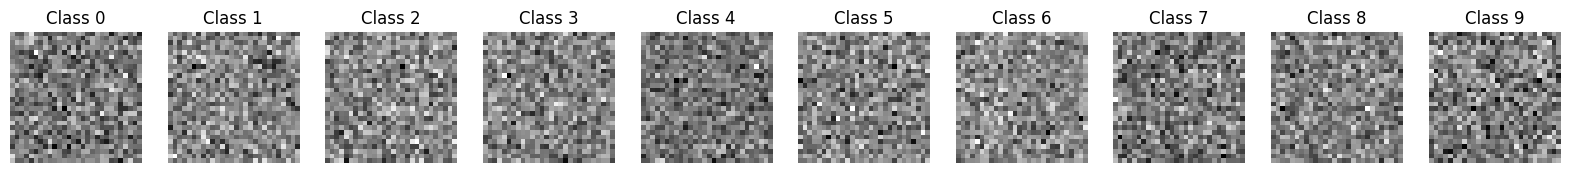

In [64]:
import matplotlib.pyplot as plt
top_model, _, _ = best_models[0]
min_weight = np.min(weights)
max_weight = np.max(weights)
rescaled_weights = (weights - min_weight) / (max_weight - min_weight) * 255
fig, axs = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    weight_image = rescaled_weights[:, i].reshape(28, 28)
    axs[i].imshow(weight_image, cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f'Class {i}')

plt.show()


&#9658; Implement the testing performance of your top 5 performing softmax models on the test set and print the results.

In [65]:
x_test, y_test = get_mnist_test_data()
x_test = (x_test - x_mean) / x_std
def test_model(model, x_test, y_test):
    predictions = model.predict(x_test)
    accuracy = np.mean(predictions == y_test.astype(int))
    return accuracy

test_accuracies = []

for model, _, _ in best_models:
    accuracy = test_model(model, x_test, y_test)
    test_accuracies.append(accuracy)

for idx, accuracy in enumerate(test_accuracies, start=1):
    print(f"Top {idx} Model Test Accuracy: {accuracy * 100:.2f}%")



Top 1 Model Test Accuracy: 17.02%
Top 2 Model Test Accuracy: 12.45%
Top 3 Model Test Accuracy: 12.40%
Top 4 Model Test Accuracy: 12.45%
Top 5 Model Test Accuracy: 10.96%


# Part 3: Deeper Neural Networks (Very Slightly)

Up until now, we have been working with linear classification models.
Linear classification models are very adept at modelling data that have nice linear boundaries.
In practice, real world data is rarely linear.
Multilayer, fully-connected neural networks with non-linear activation functions on the other hand can model non-linear data-label relationships.
Such models are a powerful extension to linear models and are the building blocks of modern deep learning.

In this section,
you will be implementing a two-layer, fully-connected neural network.
You will also implement your own version of the rectified linear unit fuction (commonly reffered to as ReLU),
a non-linear activation function.

## 3.1 ReLU Function

The ReLU function is given by:

$$
f(x) = \max(0, x)
$$

&#9658; Implement the following cell to complete the definition of the `ReLU_forward` function.

In [ ]:
def ReLU_forward(x):
    """
    Computes the forward pass for a ReLU actiivation.

    The input x has shape (N, D) and contains a minibatch of N
    examples, where each example x[i] has shape (D). We will
    transform it to an output vector of dimension M.

    Inputs:
    - x: A numpy array containing input data, of shape (N, D)


    Returns a tuple of:
    - out: output, of shape (N, D)
    - cache: (x)
    """
    out = None

    # PUT YOUR CODE BELOW: Implement the ReLU forward pass. Store the result in
    # out. You will need to reshape the input into rows.


    # The lines below do not need to be changed.

    cache = (x,)
    return out, cache

The ReLU derivative is given by:

$$
\frac{\partial f(x)}{\partial x} = \left\{
\begin{array}{ll}
      0 & x \leq 0 \\
      1 & x > 0 \\
\end{array}
\right.
$$

Where $f(x)$ is the ReLU function.

&#9658; Implement the following cell to complete the definition of the `ReLU_backward(d_upstream, cache)` function.

In [ ]:
def ReLU_backward(d_upstream, cache):
    """
    Computes the backward pass for an linear layer.

    Inputs:
    - d_upstream: Upstream derivative, of shape (N, D)
    - cache: Tuple of:
      - x: Input data, of shape (N, D)

    Returns a tuple of:
    - dx: Gradient with respect to x, of shape (N, D)
    """
    x,  = cache
    dx = None

    # PUT YOUR CODE BELOW: Implement the ReLU backward pass.

    # The lines below do not need to be changed.

    return (dx, )

## 3.2 Two-layer Neural Network

We will now implement the model for the two-layer NN.

&#9658; Implement the definition of the two-layer neural network below.

Similar to the `LinearClassifier` class, you should write the `__init__`, `forward`, `backward`, and `predict` methods. We will be using the cross-entropy loss for this network.

Complete the following:
- The `__init__()` method initializes the class. You must generate two random weight matrices. We will be using the bias trick, so the bias should concatenated to the weight matrix. They are initialized differently.

- The `forward()` method generates the scores for given an input sample, by applying a `linear_forward()` and `ReLU_forward()` with appropriate inputs. Make sure to store and return the cache for the intermediate steps.

- The `backward()` method returns the gradients with respect to the inputs and weights, using the `linear_backward()` and `ReLU_backward()`. Make sure the keys for the returned dictionary `weights_gradient` matches the keys in the `self.params` dictionary.

- The `predict()` method returns the labels predicted from the scores returned using the `self.forward()` method.


In [ ]:
class TwoLayerNet(object):
    """
    A two-layer fully-connected neural network with ReLU nonlinearity and
    softmax loss that uses a modular layer design. We assume an input dimension
    of D, a hidden dimension of H, and perform classification over C classes.

    The architecure should be transform - relu - transform - softmax.

    Note that this class does not implement gradient descent; instead, it
    will interact with a separate Solver object that is responsible for running
    optimization.

    The learnable parameters of the model are stored in the dictionary
    self.params that maps parameter names to numpy arrays.
    """
    def __init__(self,
                 input_dim,
                 hidden_dim=100,
                 num_classes=10,
                 weight_scale=1e-3):
        """
        """

        self.params = {}
        self.hidden_dim = hidden_dim
        self.input_dim = input_dim
        self.num_classes = num_classes

        # PUT YOUR CODE BELOW: Initialize the weights of the two-layer net. Weights should be
        # initialized from a Gaussian centered at 0.0 with standard deviation
        # equal to weight_scale, and biases should be initialized to zero.
        # All weights should be stored in the dictionary self.params, with first
        # layer weights and using the keys 'W1' and second layer weights and using
        # the keys 'W2'. Make sure to concatenate the weights and biases to make a
        # a single matrix for the bias trick!


        # The lines below do not need to be changed in this method.


    def forward(self, x):
        """
        Implement the forward pass of the neural network and return the scores

        Inputs:
        - x: A numpy array containing input data, of shape (N, self.input_dim)


        Returns a tuple of:
        - out: output, of shape (N, D)
        - Tuple of tuples:
          - cache_lin_1: A tuple (x, w1)
            - x: data, of shape (N, self.input_dim)
            - w1: Weight of linear layer 1 of shape (self.input_dim+1, self.hidden_dim)
          - cache_relu_1: A tuple (h, )
            - h : data, of shape (N, self.hidden_dim)
          - cache_lin_2:  A tuple (h, w2)
            - h: data, of shape (N, self.hidden_dim)
            - w2: weight of linear 2 of shape (self.hidden_dim+1, C)
        """
        out = None
        N, feature_dim = x.shape
        cache_lin_1, cache_relu_1, cache_lin_2 = None, None, None

        if (feature_dim != self.input_dim):
            raise Exception(f"The input feature dimension of {feature_dim} does \
                            not match the expected feature dimension of \
                            {self.input_dim} ")


        # PUT YOUR CODE BELOW: Perform a forward pass of the two-layer net.
        # The architecture is transform - relu - transform
        # Make to store the appropriate cache in the appropriate variables


        # The lines below do not need to be changed in this method.

        return out, (cache_lin_1, cache_relu_1, cache_lin_2)


    def backward(self, dout, cache):
        """
        Implement the backward pass of the neural network and return the
        gradients w.r.t the input, and the weights

        Inputs:
        - dout: Upstream derivative, of shape (N, C)
        - cache: Tuple of tuples:
          - cache_lin_1: A tuple (x, w1)
            - x: data, of shape (N, self.input_dim)
            - w1: Weight of linear layer 1 of shape (self.input_dim+1, self.hidden_dim)
          - cache_relu_1: A tuple (h, )
            - h : data, of shape (N, self.hidden_dim)
          - cache_lin_2:  A tuple (h, w2)
            - h: data, of shape (N, self.hidden_dim)
            - w2: weight of linear 2 of shape (self.hidden_dim+1, C)

        Returns a tuple of:
          - dx: A numpy array of the gradient with respect to x, of shape (N, D)
          - weight_gradients: A dictionary of numpy arrays containing the
              gradients with respect to the weights.
        """

        weight_gradients = {}
        dx = None

        N, classes = dout.shape

        cache_lin_1, cache_relu_1, cache_lin_2 = cache

        if (classes != self.num_classes):
            raise Exception(f"The output class dimension of {classes} does \
                            not match the expected number of classes \
                            {self.num_classes} ")

        # PUT YOUR CODE BELOW: Perform a backward pass of the two-layer net.


        # The lines below do not need to be changed in this method.
        return (dx, weight_gradients)

    def predict(self, x):

        """
        Implement the predictions from the forward pass of the neural network and
        returns it.

        Inputs:
        - x: Input data, of shape (N, self.input_dim)

        Returns a tuple of:
          - predictions: A numpy array of shape (N, ) of the predicted class per sample

        """

        y_pred = None


        # PUT YOUR CODE BELOW: Predict the classes of using the two-layer net.


        # The lines below do not need to be changed in this method.

        return y_pred

    def loss(self, scores, y_batch):
        """
        Compute the loss using the cross_entropy_loss function and its
        derivative: -1/np.sqrt(input_dim).
        Inputs:
        - scores: A numpy array of shape (N, C) containing a minibatch of N
          data points; each point has dimension C, where C is the number of classes.
        - y_batch: A numpy array of shape (N,) containing labels for the minibatch.

        Returns: A tuple containing:
        - loss as a single float
        - gradient with respect to scores; an array of the same shape as W
        """
        # The lines below do not need to be changed in this method.
        return cross_entropy_loss(scores, y_batch)

## 3.3 Experiments

Similar to the linear classifiers, you also want to identify the best configuration of hyperparameters that perform the best for your dataset. Similar to the case of the linear models, you can vary the learning rate for your solver. You should use the `Solver` class for these models as well. Use the `DATA` dictionary you defined previously as the data parameter.

Additionaly, the neural network provides another hyperparameter to vary, the the number of neurons in the hidden layer.

Adding a large of number of neurons may cause a large degradation in performance, the linear transformation scales as $O(N^3)$ with the number of neurons.

&#9658; Implement a hyperparameter validation loop in the next cell to train multiple models with different hyperparameters. Keep the top-5 best performing models on the validation set. You may change learning rate, and hidden dims. You may change the num_epochs, but be wary of timeouts.

&#9658; Implement the testing performance of your top-5 performing NN models on the test set and print the results. You can add additional cells below.

&#9658; Implement visualization for the `W1` weights of the *best* performing NN models. There are `hidden_dim` many of them per model. You should visualize a subset of the weights. You can select the columns at random.

You can add additional cells below.